# Actividad 2 - Clasificación
# Universidad Europea de Madrid
Inteligencia Artificial<br>
Isabel Sutil<br>
M31<br>
Jorge Javier Castilla Coello<br>
Geronimo Basso Sosa<br>
Luis Cabello Casquete<br>
Paula Sáenz de Santa María Diez<br>
Ana Esteban González<br>




# Codigo en común utilizado por todos los apartados.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.base import clone
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import make_scorer

# Apartado 0
Modificar el dataset para que cada vez que en "prec" se encuente el valor 0,0 se considere que no llueve, para los demas valores se va a considerar que si ha llovido

In [3]:
# Cargamos el fichero necesario para analizar el modelo.
ruta_archivo = 'valores-climatologicos.csv'
dataframe = pd.read_table(ruta_archivo, sep=',')

# Utilizando una función lambda, para cada valor de 'prec', cambiamos su valor a 0 si la precipitación es 0
# y cambiamos el valor a 1 si la precipitación es diferente de 0. Además, creamos un mapeo de indicativos de provincia
# para tener valores de tipo int en esa columna en vez de strings.
dataframe['prec'] = dataframe['prec'].apply(lambda x: 'YES' if x > 0 else 'NO')
states = ['1387E', '1387', '1393', '1351', '1400', '1437O', '1473A', '1428', '1475X', '1505', '1484', '1484C', '1495']
state_map = {state: idx for idx, state in enumerate(sorted(set(states)))}
dataframe['indicativo'] = dataframe['indicativo'].apply(lambda x: state_map[x])

# Crear un data set específico con valores de tipo float para que los modelos puedan entrenar mejor.
# dataframe = dataframe.astype(float)
columns_to_convert = ['indicativo', 'altitud', 'tmed', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'presMax', 'presMin']

# Converting each specified column to float
for column in columns_to_convert:
    dataframe[column] = dataframe[column].astype(float)

# Convertir la columna 'prec' de 'float' a 'categorical'
dataframe['prec'] = pd.Categorical(dataframe['prec'])
print(dataframe)

       indicativo  altitud  tmed prec  tmin  tmax   dir  velmedia  racha  \
0             2.0     98.0  16.9   NO  12.0  21.8   1.0       3.1    8.3   
1             2.0     98.0  20.5  YES  12.5  28.5  22.0       4.7   11.7   
2             2.0     98.0  21.4   NO  17.6  25.1  22.0       2.2   10.3   
3             2.0     98.0  21.4  YES  16.0  26.8  99.0       5.3   10.8   
4             2.0     98.0  18.6   NO  15.7  21.6   4.0       3.9   11.7   
...           ...      ...   ...  ...   ...   ...   ...       ...    ...   
11531        11.0    255.0  12.2   NO   5.5  18.8   8.0       1.7    9.7   
11532        11.0    255.0  11.2  YES   5.4  16.9  99.0       3.6    8.3   
11533        11.0    255.0   9.8  YES   6.4  13.1  27.0       1.7    7.2   
11534        11.0    255.0  11.7   NO   7.5  15.9  19.0       1.9    6.7   
11535        11.0    255.0  10.6  YES   8.7  12.6  20.0       5.0   13.9   

       presMax  presMin  
0       1008.7   1003.9  
1       1008.5   1005.5  
2       1

# Apartado 3
Análisis predictivo con KNN

# Crear el dataset de entrenamieno y validación, y además crear el cross validation.

In [4]:
X = dataframe.drop('prec', axis=1)  # Features
y = dataframe['prec']  # Variable de salida

# División en 80/20 para entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir tamaños de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de validación:", len(X_val))

# Crear conjuntos de entrenamiento y prueba
conjunto_train = pd.concat([X_train, y_train], axis=1)
conjunto_val = pd.concat([X_val, y_val], axis=1)

# Creamos dos conjuntos para poner las predicciones del train y test
conjunto_train_eval = conjunto_train.copy()
conjunto_validation_eval = conjunto_val.copy()

# Método de control (k-fold cross-validation)
metodo_control_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Tamaño del conjunto de entrenamiento: 9228
Tamaño del conjunto de validación: 2308


Entrenamos nuestro modelo con un tuneLength de 10

In [5]:
precision_train = {}
precision_val = {}

# Definir los parámetros que deseas ajustar
param_grid = {'kneighborsclassifier__n_neighbors': list(range(1, 11))}

# Establecer la semilla para reproducibilidad
np.random.seed(150)

In [6]:
# Definir el modelo KNN
knn_model = KNeighborsClassifier()

pipeline = make_pipeline(StandardScaler(), knn_model)

# Entrenar el modelo con GridSearchCV para ajustar los hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, scoring=make_scorer(accuracy_score), cv=metodo_control_cv)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

In [7]:
# Imprimir resultados
print("Mejor modelo:", best_model)

y_train_pred = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
confusion_mat_train = confusion_matrix(y_train, y_train_pred)

Mejor modelo: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=9))])


In [8]:
print("Matriz de Confusión (Train):")
print(confusion_mat_train)

Matriz de Confusión (Train):
[[3938  731]
 [ 929 3630]]


In [9]:
print("Precisión en el conjunto de entrenamiento:", accuracy_train)

precision_train['knn_tuneLength_10'] = accuracy_train

Precisión en el conjunto de entrenamiento: 0.8201127004768097


In [10]:
# Obtener los resultados del grid search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Imprimir información sobre el proceso de búsqueda
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search.best_score_)

Mejores parámetros: {'kneighborsclassifier__n_neighbors': 9}
Mejor puntuación de validación cruzada (Accuracy): 0.7801237594094518


In [11]:
# Imprimir resultados de cada conjunto de parámetros
print(resultados_df[['params', 'mean_test_score']])

                                      params  mean_test_score
0   {'kneighborsclassifier__n_neighbors': 1}         0.735259
1   {'kneighborsclassifier__n_neighbors': 2}         0.725943
2   {'kneighborsclassifier__n_neighbors': 3}         0.764844
3   {'kneighborsclassifier__n_neighbors': 4}         0.761053
4   {'kneighborsclassifier__n_neighbors': 5}         0.772864
5   {'kneighborsclassifier__n_neighbors': 6}         0.771022
6   {'kneighborsclassifier__n_neighbors': 7}         0.778824
7   {'kneighborsclassifier__n_neighbors': 8}         0.779582
8   {'kneighborsclassifier__n_neighbors': 9}         0.780124
9  {'kneighborsclassifier__n_neighbors': 10}         0.779691


In [12]:
# Crear un pipeline con escalado y clasificador KNN
model = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Lista para almacenar las puntuaciones de accuracy en cada fold y para cada conjunto de parámetros
accuracy_scores = []

# Realizar la validación cruzada
for fold, (train_idx, val_idx) in enumerate(metodo_control_cv.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    print(f"\nFold {fold + 1}:")

    for params in param_grid.values():
        for param_value in params:
            # Crear un modelo con el valor actual del parámetro
            model.set_params(kneighborsclassifier__n_neighbors=param_value)

            # Entrenar el modelo
            model.fit(X_train_fold, y_train_fold)

            # Evaluar el modelo en el conjunto de validación
            accuracy = model.score(X_val_fold, y_val_fold)

            # Imprimir la puntuación de accuracy para el valor actual del parámetro
            print(f"   {list(param_grid.keys())[0]}={param_value}, Accuracy={accuracy}")

            # Almacenar la puntuación de accuracy
            accuracy_scores.append({'Fold': fold + 1, list(param_grid.keys())[0]: param_value, 'Accuracy': accuracy})




Fold 1:
   kneighborsclassifier__n_neighbors=1, Accuracy=0.7400346620450606
   kneighborsclassifier__n_neighbors=2, Accuracy=0.7417677642980935
   kneighborsclassifier__n_neighbors=3, Accuracy=0.7729636048526863
   kneighborsclassifier__n_neighbors=4, Accuracy=0.7746967071057193
   kneighborsclassifier__n_neighbors=5, Accuracy=0.7859618717504333
   kneighborsclassifier__n_neighbors=6, Accuracy=0.7790294627383015
   kneighborsclassifier__n_neighbors=7, Accuracy=0.7807625649913345
   kneighborsclassifier__n_neighbors=8, Accuracy=0.7781629116117851
   kneighborsclassifier__n_neighbors=9, Accuracy=0.7781629116117851
   kneighborsclassifier__n_neighbors=10, Accuracy=0.7833622183708839

Fold 2:
   kneighborsclassifier__n_neighbors=1, Accuracy=0.755632582322357
   kneighborsclassifier__n_neighbors=2, Accuracy=0.7530329289428076
   kneighborsclassifier__n_neighbors=3, Accuracy=0.7920277296360485
   kneighborsclassifier__n_neighbors=4, Accuracy=0.7920277296360485
   kneighborsclassifier__n_nei

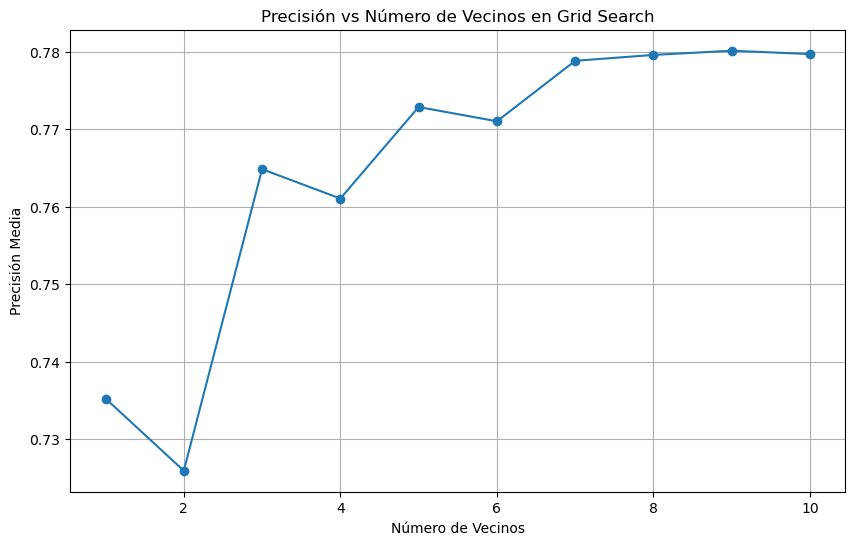

In [13]:
# Extraer los resultados del Grid Search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Obtener los valores relevantes
parametros = resultados_df['param_kneighborsclassifier__n_neighbors']
precision_media = resultados_df['mean_test_score']

# Graficar la precisión en función del número de vecinos
plt.figure(figsize=(10, 6))
plt.plot(parametros, precision_media, marker='o')
plt.title('Precisión vs Número de Vecinos en Grid Search')
plt.xlabel('Número de Vecinos')
plt.ylabel('Precisión Media')
plt.grid(True)
plt.show()

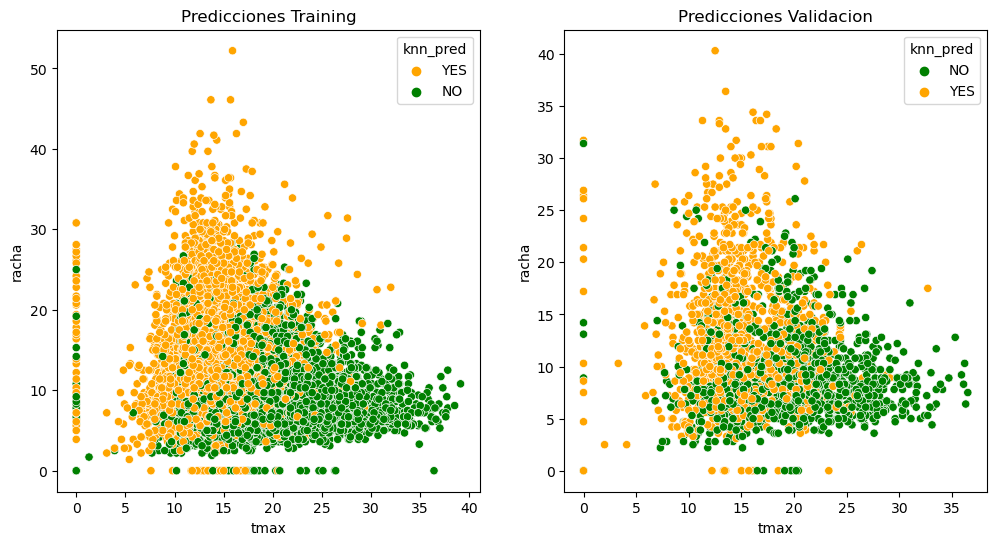

In [14]:
# Evaluación del modelo
# Training
conjunto_train_eval['knn_prob'] = best_model.predict_proba(X_train)[:, 1]
conjunto_train_eval['knn_pred'] = best_model.predict(X_train)

# Test
conjunto_validation_eval['knn_prob'] = best_model.predict_proba(X_val)[:, 1]
conjunto_validation_eval['knn_pred'] = best_model.predict(X_val)

# Asignar colores específicos a cada clase
palette = {'NO': 'green', 'YES': 'orange'}


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='tmax', y='racha', hue='knn_pred', data=conjunto_train_eval, palette=palette)
plt.title('Predicciones Training')

plt.subplot(1, 2, 2)
sns.scatterplot(x='tmax', y='racha', hue='knn_pred', data=conjunto_validation_eval, palette=palette)
plt.title('Predicciones Validacion')

plt.show()

## Validacion con un tuneLength 10

In [15]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de validación
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
confusion_mat = confusion_matrix(y_val, y_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de validación
print("Matriz de Confusión:")
print(confusion_mat)

Matriz de Confusión:
[[937 242]
 [265 864]]


In [16]:
print("Precisión en el conjunto de validación:", accuracy)
precision_val['knn_tuneLength_10'] = accuracy

Precisión en el conjunto de validación: 0.7803292894280762


# TRAIN con un grid - (1, 117, 1)

In [17]:
# Crear un pipeline con escalado y clasificador KNN
model = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Definir los parámetros que deseas ajustar
param_grid = {'kneighborsclassifier__n_neighbors': np.arange(1, 117, 1)} #1 3 5 ...

In [18]:
# Establecer la semilla para reproducibilidad
np.random.seed(150)

# Crear un pipeline con escalado de características
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalar las características
    ('model', knn_model)            # Modelo KNN
])

In [19]:
# Entrenar el modelo con GridSearchCV para ajustar los hiperparámetros
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=metodo_control_cv)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Imprimir resultados
print("Mejor modelo:", best_model)

Mejor modelo: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=11))])


In [20]:
# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
confusion_mat_train = confusion_matrix(y_train, y_train_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de entrenamiento
print("Matriz de Confusión (Train):")
print(confusion_mat_train)

Matriz de Confusión (Train):
[[3917  752]
 [ 951 3608]]


In [21]:
print("Precisión en el conjunto de entrenamiento:", accuracy_train)
precision_train['knn_tuneGrid'] = accuracy_train

Precisión en el conjunto de entrenamiento: 0.8154529692241006


In [22]:
# Obtener los resultados del grid search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Imprimir información sobre el proceso de búsqueda
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada (Accuracy):", grid_search.best_score_)


Mejores parámetros: {'kneighborsclassifier__n_neighbors': 11}
Mejor puntuación de validación cruzada (Accuracy): 0.783700114922809


In [23]:
# Imprimir resultados de cada conjunto de parámetros
print(resultados_df[['params', 'mean_test_score']])

                                         params  mean_test_score
0      {'kneighborsclassifier__n_neighbors': 1}         0.735259
1      {'kneighborsclassifier__n_neighbors': 2}         0.725943
2      {'kneighborsclassifier__n_neighbors': 3}         0.764844
3      {'kneighborsclassifier__n_neighbors': 4}         0.761053
4      {'kneighborsclassifier__n_neighbors': 5}         0.772864
..                                          ...              ...
111  {'kneighborsclassifier__n_neighbors': 112}         0.745121
112  {'kneighborsclassifier__n_neighbors': 113}         0.745770
113  {'kneighborsclassifier__n_neighbors': 114}         0.744362
114  {'kneighborsclassifier__n_neighbors': 115}         0.744795
115  {'kneighborsclassifier__n_neighbors': 116}         0.744904

[116 rows x 2 columns]


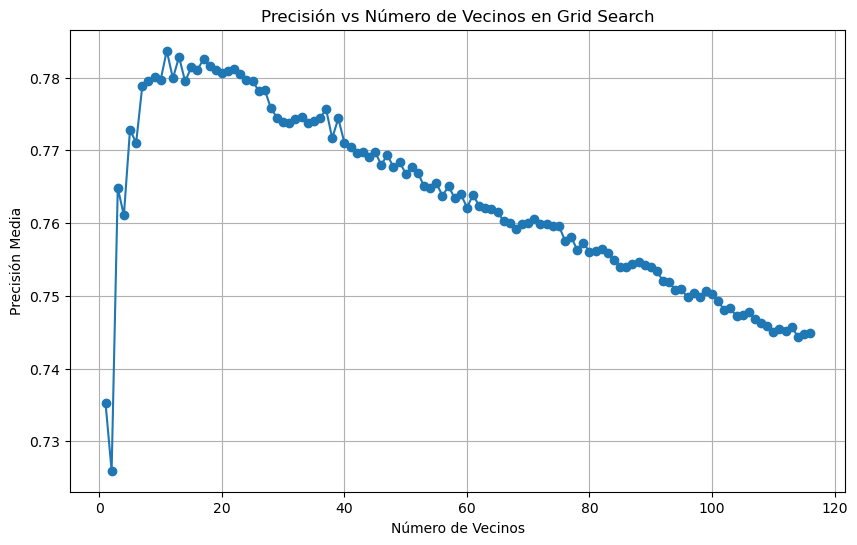

In [24]:
# Extraer los resultados del Grid Search
resultados_df = pd.DataFrame(grid_search.cv_results_)

# Obtener los valores relevantes
parametros = resultados_df['param_kneighborsclassifier__n_neighbors']
precision_media = resultados_df['mean_test_score']

# Graficar la precisión en función del número de vecinos
plt.figure(figsize=(10, 6))
plt.plot(parametros, precision_media, marker='o')
plt.title('Precisión vs Número de Vecinos en Grid Search')
plt.xlabel('Número de Vecinos')
plt.ylabel('Precisión Media')
plt.grid(True)
plt.show()

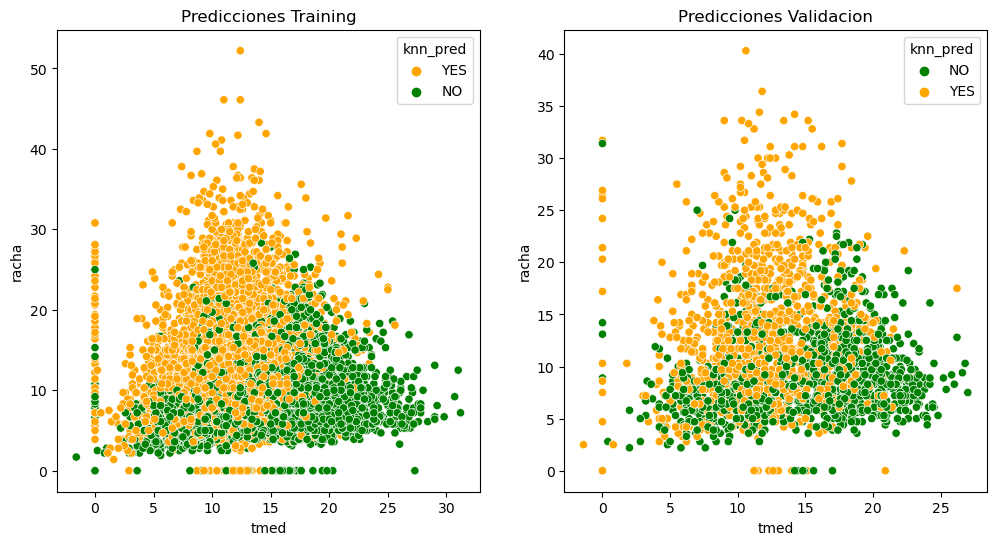

In [25]:
# Evaluación del modelo
# Training
conjunto_train_eval['knn_prob'] = best_model.predict_proba(X_train)[:, 1]
conjunto_train_eval['knn_pred'] = best_model.predict(X_train)

# Test
# Agregar probabilidades predichas para la clase positiva al conjunto de validación
conjunto_validation_eval['knn_prob'] = best_model.predict_proba(X_val)[:, 1]

# Agregar predicciones al conjunto de validación
conjunto_validation_eval['knn_pred'] = best_model.predict(X_val)

# Asignar colores específicos a cada clase
palette = {'NO': 'green', 'YES': 'orange'}

# Visualizar las predicciones en un gráfico de dispersión
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='tmed', y='racha', hue='knn_pred', data=conjunto_train_eval, palette=palette)

# Añadir título al gráfico de entrenamiento
plt.title('Predicciones Training')

plt.subplot(1, 2, 2)
sns.scatterplot(x='tmed', y='racha', hue='knn_pred', data=conjunto_validation_eval, palette=palette)

# Añadir título al gráfico de validación
plt.title('Predicciones Validacion')

# Mostramos el gráfico
plt.show()

## Validacion con un grid - (1, 117, 1)

In [26]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de validación
# Realizar predicciones en el conjunto de validación utilizando el mejor modelo
y_pred = best_model.predict(X_val)

# Calcular la precisión en el conjunto de validación
accuracy = accuracy_score(y_val, y_pred)

# Calcular la matriz de confusión en el conjunto de validación
confusion_mat = confusion_matrix(y_val, y_pred)

# Imprimir la matriz de confusión y la precisión en el conjunto de validación
print("Matriz de Confusión:")
print(confusion_mat)


Matriz de Confusión:
[[942 237]
 [264 865]]


In [27]:
# Imprimir la precisión en el conjunto de validación
print("Precisión en el conjunto de validación:", accuracy)
precision_val['knn_tuneGrid'] = accuracy

Precisión en el conjunto de validación: 0.7829289428076257


## Train con un K=11

In [28]:
# Crear un nuevo modelo con K=19
knn_model_k11 = KNeighborsClassifier(n_neighbors=11)

# Crear un nuevo pipeline con el nuevo modelo
model_k11 = make_pipeline(StandardScaler(), knn_model_k11)

In [29]:
# Método de control (k-fold cross-validation)
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lista para almacenar las puntuaciones de validación cruzada
cv_scores_k11 = []

# Realizar k-fold cross-validation
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train, y_train), 1):
    
    # Dividir el conjunto de entrenamiento en conjuntos de entrenamiento y validación para la iteración actual del k-fold cross-validation
    # Conjunto de características de entrenamiento y validación
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    
    # Conjunto de etiquetas de entrenamiento y validación
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Entrenar el modelo en el conjunto de entrenamiento actual
    model_k11.fit(X_train_fold, y_train_fold)

    # Evaluar el modelo en el conjunto de validación actual
    y_val_pred = model_k11.predict(X_val_fold)
    accuracy_val_fold = accuracy_score(y_val_fold, y_val_pred)

    # Imprimir la precisión en el fold actual
    print(f"Fold {fold}: Precisión en validación = {accuracy_val_fold}")



Fold 1: Precisión en validación = 0.7681473456121344
Fold 2: Precisión en validación = 0.7768147345612134
Fold 3: Precisión en validación = 0.7822318526543879
Fold 4: Precisión en validación = 0.7778981581798483
Fold 5: Precisión en validación = 0.8049837486457205
Fold 6: Precisión en validación = 0.8017334777898159
Fold 7: Precisión en validación = 0.7800650054171181
Fold 8: Precisión en validación = 0.7930660888407367
Fold 9: Precisión en validación = 0.7657266811279827
Fold 10: Precisión en validación = 0.7863340563991323


In [30]:
# Evaluar el modelo con K=11 en el conjunto de entrenamiento
# Predecir utilizando el modelo con K=11
y_train_pred_k11 = model_k11.predict(X_train)

# Calcular precisión en entrenamiento
accuracy_train_k11 = accuracy_score(y_train, y_train_pred_k11)

# Calcular matriz de confusión en entrenamiento
confusion_mat_train_k11 = confusion_matrix(y_train, y_train_pred_k11)

# Imprimir la matriz de confusión y la precisión en el conjunto de entrenamiento con K=11
print("Matriz de Confusión (Train) con K=11:")
print(confusion_mat_train_k11)

Matriz de Confusión (Train) con K=11:
[[3910  759]
 [ 970 3589]]


In [31]:
# Imprimir la precisión en el conjunto de entrenamiento con K=11
print("Precisión en el conjunto de entrenamiento con K=11:", accuracy_train_k11)

# Agregar la precisión al diccionario 'precision_train' con la clave 'knn_11'
# Almacenar la precisión en el diccionario 'precision_train' bajo la clave 'knn_11'
precision_train['knn_11'] = accuracy_train_k11

Precisión en el conjunto de entrenamiento con K=11: 0.8126354573038578


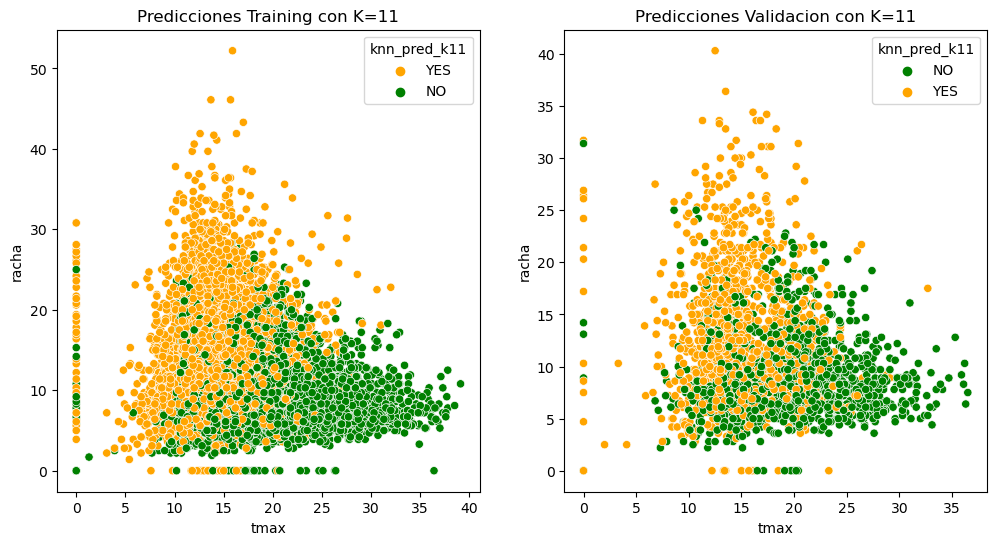

In [32]:
# Entrenar el modelo con todos los datos de entrenamiento
model_k11.fit(X_train, y_train)

# Agregar probabilidades y predicciones al conjunto de entrenamiento
conjunto_train_eval['knn_prob_k11'] = model_k11.predict_proba(X_train)[:, 1]
conjunto_train_eval['knn_pred_k11'] = model_k11.predict(X_train)

# Agregar probabilidades y predicciones al conjunto de validación
conjunto_validation_eval['knn_prob_k11'] = model_k11.predict_proba(X_val)[:, 1]
conjunto_validation_eval['knn_pred_k11'] = model_k11.predict(X_val)

# Visualizar las predicciones en un gráfico de dispersión
# Definimos lo colores para las clases del gráfico
palette = {'NO': 'green', 'YES': 'orange'}

# Configuramos el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Generamos el subgráfico 1: Gráfico de dispersión para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
sns.scatterplot(x='tmax', y='racha', hue='knn_pred_k11', data=conjunto_train_eval, palette=palette)

# Añadimos título al gráfico
plt.title('Predicciones Training con K=11')

# Generamos el subgráfico 2: Gráfico de dispersión para el conjunto de validación
plt.subplot(1, 2, 2)
sns.scatterplot(x='tmax', y='racha', hue='knn_pred_k11', data=conjunto_validation_eval, palette=palette)

# Añadimos el título al gráfico
plt.title('Predicciones Validacion con K=11')

plt.show()

## Validacion con k= 11

In [33]:
# Evaluar el modelo con K=25 en el conjunto de validación

# Predecimos las etiquetas en el conjunto de validación utilizando el modelo con K=11
y_val_pred_k11 = model_k11.predict(X_val)

# Calculamos la precisión en el conjunto de validación
accuracy_val_k11 = accuracy_score(y_val, y_val_pred_k11)

# Calculamos la matriz de confusión en el conjunto de validación
confusion_mat_val_k11 = confusion_matrix(y_val, y_val_pred_k11)

# Imprimir la matriz de confusión y la precisión en el conjunto de validación con K=11
print("Matriz de Confusión (Validation) con K=11:")
print(confusion_mat_val_k11)

Matriz de Confusión (Validation) con K=11:
[[942 237]
 [264 865]]


In [34]:
# Imprimir la precisión en el conjunto de validación con K=11
print("Precisión en el conjunto de validación con K=11:", accuracy_val_k11)

# Agregar la precisión al diccionario 'precision_val' con la clave 'knn_11'
# Almacenar la precisión en el diccionario 'precision_val' bajo la clave 'knn_11'
precision_val['knn_11'] = accuracy_val_k11

Precisión en el conjunto de validación con K=11: 0.7829289428076257


In [37]:
# **CONCLUSIONES**

# Ordenar el diccionario por sus valores de mayor a menor
precision_train_ordenada = dict(sorted(precision_train.items(), key=lambda item: item[1], reverse=True))

# Imprimir la precisión en el conjunto de validación ordenada de mayor a menor
print("Precisión en el conjunto de train (de mayor a menor:")
      
# Bucle para imprimir la precisión en el conjunto de entrenamiento ordenada de mayor a menor
for nombre_variable, valor in precision_train_ordenada.items():
    print(f"{nombre_variable}: {valor}")

# Ordenar el diccionario por sus valores de mayor a menor
precision_val_ordenada = dict(sorted(precision_val.items(), key=lambda item: item[1], reverse=True))

# Imprimir la precisión en el conjunto de validación ordenada de mayor a menor
print("Precisión en el conjunto de validación (de mayor a menor):")
      
# Bucle para imprimir la precisión en el conjunto de validación ordenada de mayor a menor
for nombre_variable, valor in precision_val_ordenada.items():
    print(f"{nombre_variable}: {valor}")

Precisión en el conjunto de train (de mayor a menor:
knn_tuneLength_10: 0.8201127004768097
knn_tuneGrid: 0.8154529692241006
knn_11: 0.8126354573038578
Precisión en el conjunto de validación (de mayor a menor):
knn_tuneGrid: 0.7829289428076257
knn_11: 0.7829289428076257
knn_tuneLength_10: 0.7803292894280762


## Conclusiones Combinadas sobre el Modelo K-Nearest Neighbors (K-NN)

### Elección del Mejor Modelo y Observaciones de la Validación Cruzada

Inicialmente, identificamos que el modelo alcanza su mayor precisión en entrenamiento con `k=9`, logrando un 78%. Sin embargo, al observar la gráfica de la regla del codo, notamos un posible sobreajuste para `k=9`. Esto nos llevó a considerar `k=7` como una opción más equilibrada. 

Posteriormente, al expandir el rango de vecinos en un grid de (1,117,1), descubrimos que `k=11` era óptimo, alcanzando una precisión del 78.4%. La gráfica del codo para este rango también sugiere que `k=11` es una elección prudente, mostrando menos señales de sobreajuste.

### Matriz de Confusión y Precisión en Entrenamiento y Validación

Con `k=11`, logramos una precisión del 81.35% en el conjunto de entrenamiento y del 78.37% en el conjunto de validación, ambas obtenidas utilizando validación cruzada. La matriz de confusión para `k=11` muestra un buen balance entre verdaderos positivos y negativos, aunque con una cantidad notable de falsos negativos y positivos.

### Reflexiones Finales

Este análisis demuestra que `k=11` ofrece un balance adecuado para nuestro modelo, superando los resultados previamente obtenidos con la regresión logística. Esto sugiere una mejor capacidad de predicción y robustez del modelo K-NN para nuestro dataset. 

En conclusión, el modelo K-NN ha demostrado ser efectivo para la predicción meteorológica en este contexto específico. Aunque hay espacio para mejorar en términos de reducción de errores de clasificación, el modelo muestra una buena consistencia y capacidad de predicción.